Influenced by:

https://arxiv.org/abs/2210.02747

https://github.com/atong01/conditional-flow-matching

https://arxiv.org/abs/2302.00482

In [ ]:
%%capture

!pip install torchsde
!pip install torchdyn
!pip install torchcfm
!pip install diffusers[training]==0.2.3
!pip install "ipywidgets>=7,<8"

In [ ]:
%%capture
%load_ext autoreload
%autoreload 2

import os
import math
import numpy as np
from functools import partial
from typing import Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from PIL import ImageFilter
from tqdm import tqdm
import torchsde
from torchdyn.core import NeuralODE
import ot as pot
from torchcfm.models.unet import UNetModel

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%%capture

batch_size = 128 #@param {'type':'integer'}
#radius defines the blur radius
radius = 3 #@param {'type':'integer'}

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class GaussianBlur:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    GaussianBlur(radius=radius),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class PairedMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, lr_transform=None):
        self.dataset = datasets.MNIST(root=root, train=train, download=True, transform=transform)
        self.lr_transform = lr_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        hr_image, label = self.dataset[idx]
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

paired_dataset_train = PairedMNIST(
    root="../data",
    train=True,
    transform=transformations,
    lr_transform=blur_transform
)

train_data_loader = DataLoader(
    dataset=paired_dataset_train,
    batch_size =batch_size,
    shuffle=True,
    drop_last=True
)

paired_dataset_test = PairedMNIST(
    root="../data",
    train=False,
    transform=transformations,
    lr_transform= blur_transform
)

test_data_loader = DataLoader(
    dataset= paired_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)


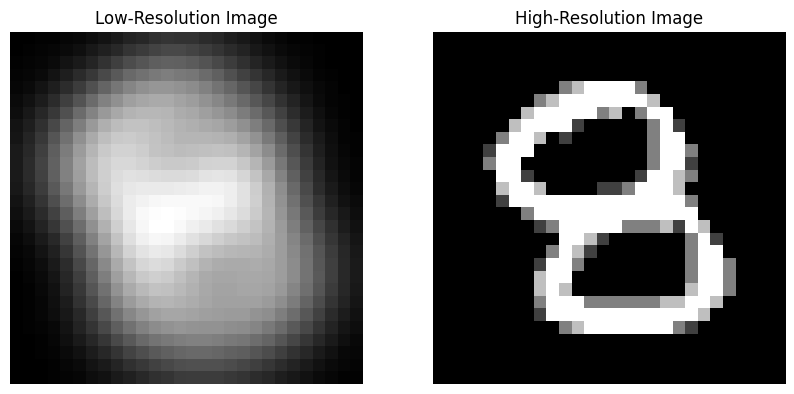

In [ ]:
#@title blur visualisation
data_iter = iter(train_data_loader)
lr_images, hr_images = next(data_iter)

lr_image_sample = lr_images[0]
hr_image_sample = hr_images[0]

def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    tensor = tensor.numpy()
    return np.transpose(tensor, (1, 2, 0))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Low-Resolution Image")
plt.imshow(denormalize(lr_image_sample), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("High-Resolution Image")
plt.imshow(denormalize(hr_image_sample), cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
def redim_t(t, x):
    """reshapes the time vector t by the number of dimensions of x."""
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))

In [ ]:
#@title flowmatcher

class flowmatcher:
    """
    super res flow matching implementation

    independent coupling implementation from using eq 14 and 15 from atong
    """

    def __init__(self, sigma=0.):
        self.sigma = sigma

    def get_mu_t(self, x0, x1, t):
        """
        Calculates mu t
        """
        t = redim_t(t, x0).to(x0.device)
        return (1 - t) * x0 + t * x1

    def sample_xt(self, x0, x1, t, eps):
        """Sample xt at timestep t given a normal variable eps"""
        mu_t = self.get_mu_t(x0, x1, t)
        sigma_t = redim_t(self.sigma, x0)
        return mu_t + sigma_t * eps

    def sample_location_and_flow(self, x0, x1, t):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)

        eps = torch.randn_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = x1-x0

        return t, xt, ut

In [ ]:
#@title optimal transport flowmatcher

class otcalculator():
    """calculates the ot plan under L2 loss"""
    def __init__(self):
        self.ot_fn = partial(pot.emd, numThreads=1)

    def get_map(self, x0, x1):
        n1 = x0.shape[0]
        n2 = x1.shape[0]

        a = np.full(n1, 1 / n1)
        b = np.full(n2, 1 / n2)


        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)

        M = torch.cdist(x0, x1) ** 2

        p = self.ot_fn(a, b, M.detach().cpu().numpy())

        return p

    def sample_map(self,map,batch_size):
        p = map.flatten()
        p /= p.sum()
        choices = np.random.choice(
            map.shape[0] * map.shape[1], p=p, size=batch_size, replace=True
        )
        return np.divmod(choices, map.shape[1])

    def sample_plan(self, x0, x1):
        map = self.get_map(x0, x1)
        i, j = self.sample_map(map, x0.shape[0])
        return x0[i], x1[j]


class otflowmatcher(flowmatcher):
    """
    optimal transport flow matching implementation
    section 3.2.3 from atong paper

    replaces the methods used in the independent coupling implementation
    with the methods used in optimal transport
    """

    def __init__(self, sigma=0.):
        super().__init__(sigma)
        self.ot = otcalculator()

    def sample_location_and_flow(self, x0, x1, t=None):
        a,b = self.ot.sample_plan(x0,x1)

        return super().sample_location_and_flow(a, b, t)

In [ ]:
#@title loss function

def get_loss(x,y):
  return torch.mean((x-y)**2)

In [ ]:
#@title hyperparameters and model setup

sigma = 0 #@param {'type':'number'}
num_channels = 64 #@param {'type':'number'}
num_res_blocks = 3 #@param {'type':'number'}
num_epochs = 50 #@param {'type':'number'}

model = UNetModel(dim=(1, 28, 28), num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters())
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

fm = flowmatcher(sigma)
# fm = otflowmatcher(sigma)

In [ ]:
#@title training

for epoch in range(n_epochs):
    print(epoch)
    for i, data in enumerate(train_data_loader):
        optimizer.zero_grad()
        x1 = data[1].to(device)
        x0 = data[0].to(device)

        t, xt, ut = fm.sample_location_and_flow(x0, x1)

        vt = model(t, xt)

        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
final_checkpoint_path = f'/content/drive/My Drive/Dissertation/models/superres_ot_50epoch_3res_64chan.pth'

torch.save(model.state_dict(), final_checkpoint_path)
print(f'Saved final model checkpoint: {final_checkpoint_path}')

In [ ]:
%%capture
#@title Load the model in

checkpoint_path = '/content/drive/My Drive/Dissertation/models/superres_ot_50epoch_3res_64chan.pth' #@param {type:"string"}
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

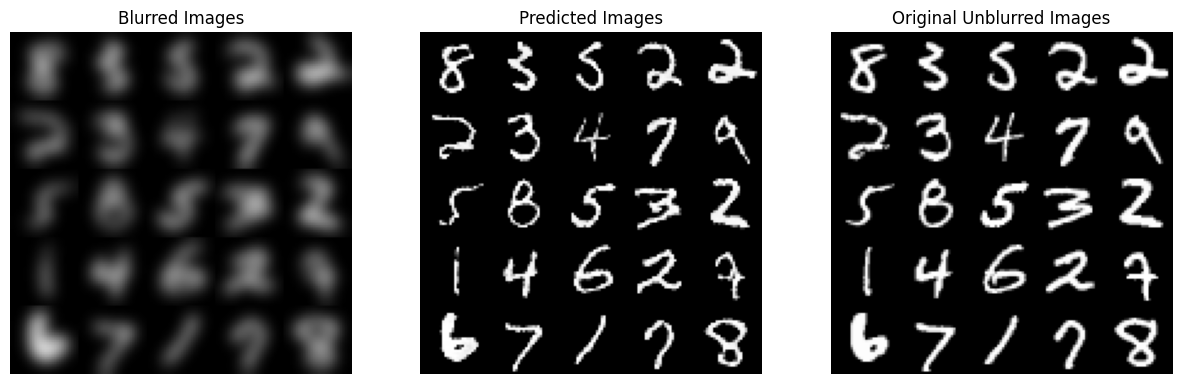

In [ ]:
#@title sampling

num_images = 16 #@param {'type':'integer'}
num_steps = 10 #@param {'type':'integer'}
completion = 1 #@param {'type':'number'}

nrow = int(math.sqrt(num_images))

blurred_images, unblurred_images = next(iter(test_data_loader))

blurred_images = blurred_images[:num_images].to(device)
unblurred_images = unblurred_images[:num_images].to(device)

with torch.no_grad():
    traj = node.trajectory(
        blurred_images,
        t_span=torch.linspace(0, 1, num_steps, device=device),
    )

predicted_grid = make_grid(
    traj[int((num_steps - 1) * completion), :num_images].view([-1, 1, 28, 28]).clip(0, 1),
    value_range=(-1, 1),
    padding=0,
    nrow=nrow
)

predicted_img = ToPILImage()(predicted_grid)

def denormalize(imgs):
    return (imgs + 1) / 2

blurred_images_denorm = denormalize(blurred_images)
unblurred_images_denorm = denormalize(unblurred_images)

blurred_grid = make_grid(
    blurred_images_denorm.view([-1, 1, 28, 28]),
    value_range=(0, 1),
    padding=0,
    nrow=nrow
)

unblurred_grid = make_grid(
    unblurred_images_denorm.view([-1, 1, 28, 28]),
    value_range=(0, 1),
    padding=0,
    nrow=nrow
)

blurred_img = ToPILImage()(blurred_grid)
unblurred_img = ToPILImage()(unblurred_grid)

plt.figure(figsize=(15, 5))

# blurred images
plt.subplot(1, 3, 1)
plt.imshow(blurred_img, cmap='gray')
plt.title("Blurred Images")
plt.axis('off')

# predicted images
plt.subplot(1, 3, 2)
plt.imshow(predicted_img, cmap='gray')
plt.title("Predicted Images")
plt.axis('off')

# original unblurred images
plt.subplot(1, 3, 3)
plt.imshow(unblurred_img, cmap='gray')
plt.title("Original Unblurred Images")
plt.axis('off')

plt.show()


In [ ]:
#@title Sampling for FID

num_images = 10000 #@param {'type':'integer'}
num_steps = 10 #@param {'type':'integer'}
batch_size = 100  #@param {'type':'integer'}
completion = 1 #@param {'type':'number'}
start_index = 0 #@param {'type':'integer'}
save_dir = "/content/drive/My Drive/Dissertation/images/superres_ot"


paired_dataset_test = PairedMNIST(
    root="../data",
    train=False,
    transform=transformations,
    lr_transform=blur_transform
)

test_data_loader = DataLoader(
    dataset=paired_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

os.makedirs(save_dir, exist_ok=True)

to_pil = ToPILImage()

with torch.no_grad():
    for start_idx in range(start_index, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        current_batch_size = end_idx - start_idx

        blurred_images, _ = next(iter(test_data_loader))
        blurred_images = blurred_images[:num_images].to(device)

        traj = node.trajectory(
            blurred_images,
            t_span=torch.linspace(0, 1, num_steps, device=device),
        )

        samples = traj[int((num_steps - 1) * completion), :current_batch_size].view([-1, 1, 28, 28]).clip(0, 1)

        for i, sample in enumerate(samples):
            img = to_pil(sample)
            img.save(os.path.join(save_dir, f"sample_{start_idx + i + 1}.png"))